In [0]:
### https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/
### https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
%%time

# This is the two-step process used to prepare the
# data for use with the convolutional neural network.

# First step is to convert Python Image Library (PIL) format
# to PyTorch tensors.

# Second step is used to normalize the data by specifying a 
# mean and standard deviation for each of the three channels.
# This will convert the data from [0,1] to [-1,1]

# Normalization of data should help speed up conversion and
# reduce the chance of vanishing gradients with certain 
# activation functions.
batch_size = 256
T=transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
## Downloading Train dataset
train = torchvision.datasets.CIFAR10('/file/',train=True,download =True,transform = T)
train = torch.utils.data.DataLoader(train,batch_size = batch_size,shuffle=True)


## Downloading Test dataset
test = torchvision.datasets.CIFAR10('/file/',train=False,download =True,transform = T)
test = torch.utils.data.DataLoader(test,batch_size = batch_size ,shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 1.58 s, sys: 437 ms, total: 2.01 s
Wall time: 2.02 s


In [4]:
for index,(images,labels) in enumerate(train):
  print(index,images.size(),len(labels))
  break ## for single example

0 torch.Size([256, 3, 32, 32]) 256


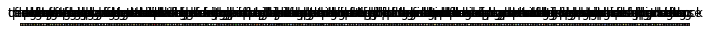

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(train)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,12))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [0]:
## For finding the transformation bw last conv layer and 1st fc.
'''
conv1 = nn.Conv2d(in_channels = 3,out_channels = 12 ,kernel_size = 5,stride=1)
pool1 =nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(in_channels = 12,out_channels =6,kernel_size = 3)
x = conv1(images)
x = pool1(x)
x = conv2(x)
x.shape
''

In [0]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    '''
    http://cs231n.github.io/convolutional-networks/
  
    '''
    self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 12 ,kernel_size = 5,stride=1)
    self.pool1 =nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(in_channels = 12,out_channels =6,kernel_size = 3) ## conv1 output = conv2 input
    self.fc1 = nn.Linear(6*12*12,32)
    self.fc2 = nn.Linear(32,10) ## 10 is number of class
  
  def forward(self,x):
    x = torch.relu(self.conv1(x))
    x = self.pool1(x)
    x = torch.relu(self.conv2(x))
    x = x.view(-1,6*12*12) ## Flattening of Image
    x = self.fc1(x)
    out = self.fc2(x)
    
    return out


In [7]:
model = ConvNet().to(device)
print('Archeitiecture of Model',model)

Archeitiecture of Model ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 6, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=864, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [8]:
%%time
from torch.autograd import Variable

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters() , lr = .001)
n_total_steps = len(train)
num_epochs = 15
lossess = list()
for epoch in range(num_epochs):
  for index, (images, labels) in enumerate(train):
    images = Variable(images.to(device))
    labels = Variable(labels.to(device))
    output = model(images)

    loss = criteria(output,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 3 == 0:
    lossess.append(loss.item())
    print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))

print('Finished Training')

Epoch: 1 - Loss: 1.467806
Epoch: 4 - Loss: 1.217249
Epoch: 7 - Loss: 1.371839
Epoch: 10 - Loss: 1.057194
Epoch: 13 - Loss: 1.381242
Finished Training
CPU times: user 6min 3s, sys: 7.32 s, total: 6min 10s
Wall time: 6min 11s


In [0]:
dataiter = iter(test)
images, labels = dataiter.next()

In [10]:
images.size()

torch.Size([256, 3, 32, 32])

In [11]:
## test contains 39 smaple each have 256 batches so total number of images are 39*256
output = model(images)
print(output.size())
### 256 are number of batch and 10 is class

torch.Size([256, 10])


In [12]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(output)
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i], p))

truck - 0.8137
bird - 0.8313
dog - 0.4230
dog - 0.6013
car - 0.6060
dog - 0.5952
frog - 0.6104
car - 0.9228
horse - 0.9203
ship - 0.9281
cat - 0.3155
ship - 0.3519
frog - 0.5544
bird - 0.4469
cat - 0.4347
frog - 0.9994
plane - 0.7887
dog - 0.6373
car - 0.9843
deer - 0.2899
plane - 0.4135
plane - 0.3833
bird - 0.4470
plane - 0.5690
ship - 0.4904
plane - 0.5298
bird - 0.4068
plane - 0.6869
ship - 0.7816
dog - 0.5933
cat - 0.4224
deer - 0.2447
car - 0.3459
dog - 0.3288
deer - 0.6062
horse - 0.2334
ship - 0.7587
truck - 0.9815
horse - 0.4728
plane - 0.2172
ship - 0.7195
plane - 0.2435
cat - 0.4430
cat - 0.2519
bird - 0.3079
horse - 0.8491
ship - 0.9301
plane - 0.4100
plane - 0.6774
car - 0.8471
car - 0.5964
frog - 0.4723
car - 0.8792
deer - 0.6648
horse - 0.4453
plane - 0.7208
dog - 0.2595
truck - 0.4324
car - 0.3388
bird - 0.3321
ship - 0.3986
plane - 0.7450
plane - 0.5248
plane - 0.5760
horse - 0.5405
dog - 0.8689
cat - 0.3455
car - 0.7484
truck - 0.7934
frog - 0.7356
car - 0.9036
horse 

In [13]:
labels.size(0)

256

In [14]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in test:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 58.37%


In [15]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 54.4
car        - 69.5
bird       - 40.6
cat        - 35.4
deer       - 52.3
dog        - 51.6
frog       - 71.2
horse      - 71.3
ship       - 71.8
truck      - 65.6


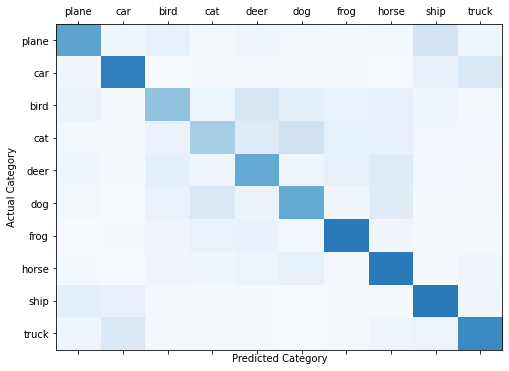

In [16]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()
